<a href="https://colab.research.google.com/gist/qbeer/c7630c11339b659843e32e39eb732e42/hw5_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

## Logistic regression

### 1. Download data from https://science.sciencemag.org/content/359/6378/926 (supplementary materials).

* read the abstract of the article to get familiar with data origin
* open the data in excel and get familiar with its content
* load the protein level data (you need to figure out which one is that) as a pandas dataframe
* handle missing values and convert features to numeric values when it is needed
* get rid of the unnecessary (which does not encode protein levels or the tumor type) columns and the CancerSEEK results

In [2]:
orig_df = pd.read_excel('aar3247_cohen_sm_tables-s1-s11.xlsx', sheet_name=5,skiprows=2)
df = orig_df.copy()

In [3]:
def value_integerizer(dataframe, column):
    col_name, _ = np.unique(dataframe[column].astype(str),return_counts=True)
    dataframe[column] = dataframe[column].replace(to_replace=col_name, value=([x+1 for x in range(len(col_name))]))
    print(col_name)
    return dataframe

def accuracy(arr1, arr2):
    """arr1: train
       arr2: test
       """
    values,count = np.unique(arr1 - arr2, return_counts=True)
    return count[values == 0][0]/sum(count)

In [4]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1820 non-null   object 
 1   Sample ID #                           1817 non-null   object 
 2   Tumor type                            1817 non-null   object 
 3   AJCC Stage                            1005 non-null   object 
 4   AFP (pg/ml)                           1817 non-null   object 
 5   Angiopoietin-2 (pg/ml)                1817 non-null   object 
 6   AXL (pg/ml)                           1811 non-null   float64
 7   CA-125 (U/ml)                         1817 non-null   object 
 8   CA 15-3 (U/ml)                        1817 non-null   object 
 9   CA19-9 (U/ml)                         1817 non-null   object 
 10  CD44 (ng/ml)                          1811 non-null   object 
 11  CEA (pg/ml)      

In [5]:
orig_df[orig_df['Tumor type'] == 'Normal']

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
888,LCR 588,LCR 588 PLS1,Normal,NaN,2003.87,957.85,2674.11,12.5,20.62,20.76,...,*200.436,230.06,8619.04,9546.90,*16.692,5997.52,76809.87,72452.91,0.233768,Negative
889,LCR 589,LCR 589 PLS1,Normal,NaN,1477.71,955.15,2298.18,5.43,4.3,*16.344,...,*200.436,38.86,7382.92,7896.55,*16.692,2865.38,55109.08,47813.87,0.324800,Negative
890,LCR 590,LCR 590 PLS1,Normal,NaN,*913.98,1267.35,3851.64,8.93,15.4,*16.344,...,*200.436,51.79,6571.18,8355.38,*16.692,1233.01,44360.32,42867.39,0.334918,Negative
891,LCR 591,LCR 591 PLS1,Normal,NaN,*913.98,395.1,3761.80,*4.884,24.18,*16.344,...,*200.436,59.96,5251.27,7226.50,*16.692,*688,53239.59,46924.19,0.185293,Negative
892,LCR 592,LCR 592 PLS1,Normal,NaN,2782.15,759.62,3411.16,*4.884,10.49,*16.344,...,*200.436,39.37,5191.54,7320.91,*16.692,10500.61,89932.52,54069.72,0.296718,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,NL,NL PLSA 1866,Normal,NaN,*740.016,1683.29,2151.58,*4.608,4.93,*15.912,...,1237.14,60.85,5139.9,5071.28,*15.258,*835,59951.49,44169.16,0.169246,Negative
1699,NL,NL PLSA 1867,Normal,NaN,*740.016,802.16,1069.51,*4.608,31.17,*15.912,...,1237.14,24.3,4050.87,3317.55,*15.258,1370.01,59816.96,40469.19,0.095699,Negative
1700,NL,NL PLSA 1868,Normal,NaN,*740.016,1112.37,1606.96,*4.608,21.21,*15.912,...,623.75,14.6,3449.88,3141.06,*15.258,*835,59579.84,40979.86,0.154097,Negative
1701,NL,NL PLSA 1869,Normal,NaN,*740.016,583.62,1708.47,*4.608,15.13,*15.912,...,1142.23,28.83,3948.14,4318.48,*15.258,*835,67033.91,40559.19,0.118664,Negative


In [6]:
df['AJCC Stage'] = orig_df['AJCC Stage'].replace(to_replace=np.NaN, value=0)

In [7]:
df = value_integerizer(df,'Tumor type')
df = value_integerizer(df,'AJCC Stage')

['Breast' 'Colorectum' 'Esophagus' 'Liver' 'Lung' 'Normal' 'Ovary'
 'Pancreas' 'Stomach' 'nan']
['0' 'I' 'II' 'III']


In [8]:
df_full = df.copy()
df = df.drop(df.columns[0:2],axis=1)
df = df.drop(df.columns[-1],axis=1)
df = df.drop(df.columns[-1],axis=1)

In [9]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tumor type                   1803 non-null   float64
 1   AJCC Stage                   1803 non-null   int64  
 2   AFP (pg/ml)                  1803 non-null   object 
 3   Angiopoietin-2 (pg/ml)       1803 non-null   object 
 4   AXL (pg/ml)                  1803 non-null   float64
 5   CA-125 (U/ml)                1803 non-null   object 
 6   CA 15-3 (U/ml)               1803 non-null   object 
 7   CA19-9 (U/ml)                1803 non-null   object 
 8   CD44 (ng/ml)                 1803 non-null   object 
 9   CEA (pg/ml)                  1803 non-null   object 
 10  CYFRA 21-1 (pg/ml)           1803 non-null   object 
 11  DKK1 (ng/ml)                 1803 non-null   object 
 12  Endoglin (pg/ml)             1803 non-null   object 
 13  FGF2 (pg/ml)      

In [10]:
for col in df.columns:
    if df[col].dtypes == 'object': #if the column contains string as well
        df[col] = df[col].replace(to_replace='^\D+', #remove the * or any non digit and cast to float
                                  value='',
                                  regex=True).astype(dtype=float) 

In [11]:
tumor_types = ['Breast', 'Colorectum', 'Esophagus', 'Liver', 'Lung', 'Normal', 'Ovary','Pancreas', 'Stomach']

### 2. Predict if a sample is cancerous or not

* your need to build a classifier that predicts the probability of a sample coming from a cancerous (tumor type is normal or not) person based on the measured protein levels
* train a logistic regression (sklearn API) on every second sample (not first 50% of the data (!), use every second line)
* generate prediction for the samples that were not used during the training

In [12]:
# from https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

In [13]:
df_2 = df.copy()

In [14]:
col_name, _ = np.unique(df['Tumor type'].astype(str),return_counts=True)
df_2['Tumor type'] = df['Tumor type'].replace(to_replace=col_name, value=([x+1 for x in range(len(col_name))]))

In [15]:
df_2['Tumor type'][df['Tumor type'] != 6.0] = 0
df_2['Tumor type'][df['Tumor type'] == 6.0] = 1

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
#How many tumor and normal data we have
df_2['Tumor type'].value_counts()

0.0    1004
1.0     799
Name: Tumor type, dtype: int64

In [17]:
X = df_2[df_2.columns[1:]]
X_train = X[::2]
X_test = X[1::2]

y = df_2[df_2.columns[0]]
y_train = y[::2]
y_test = y[1::2]

clf = LogisticRegression().fit(X_train, y_train)

ypred1 = clf.predict(X_test)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

In [18]:
print(accuracy(y_test,ypred1))
score = clf.score(X_test, y_test)
print(score)

0.8657047724750278
0.8657047724750278


/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


###  3. Comparision to CancerSEEK
* plot the ROC curve and calculate the confusion matrix for the predictions
* do the same for the CancerSEEK predictions
* compare your model's performance to CancerSEEK performance

### Creating ROC curve

In [19]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
y_score = clf.decision_function(X_test) #confidence score

# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)

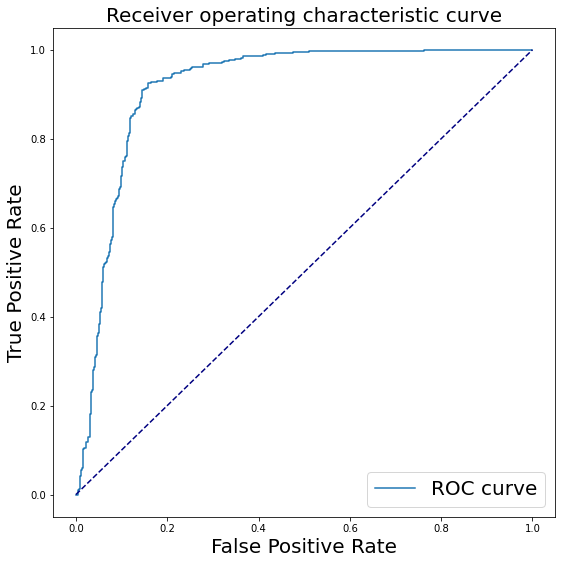

In [20]:
plt.figure(figsize=(9,9))
plt.plot(fpr,tpr,label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver operating characteristic curve',fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [21]:
print('Area under ROC %.10f' %roc_auc)

Area under ROC 0.9156656582


In [22]:
cm = metrics.confusion_matrix(y_test, ypred1)
print(cm)

[[432  70]
 [ 51 348]]


Text(0.5, 1.0, 'Accuracy Score: 0.865705')

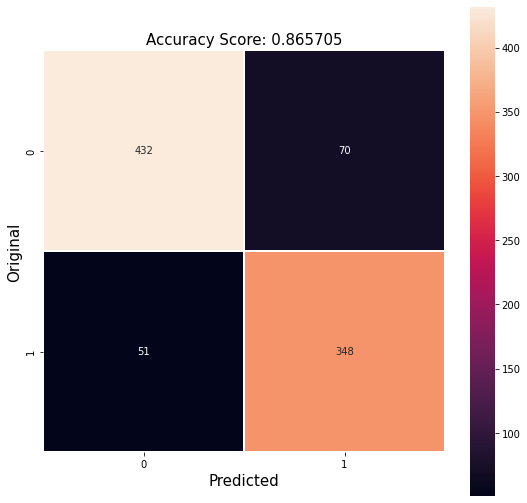

In [23]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, 
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True)
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)
all_sample_title = 'Accuracy Score: %f' % score
plt.title(all_sample_title, size = 15)

In [24]:
Tn, Fp, Fn, Tp = metrics.confusion_matrix(y_test, ypred1).ravel()

# Compare with CancerSeek

In [25]:
#Do the same as at the beginning
df_full = df_full.dropna().reset_index(drop=True)
for col in df_full.columns[2:-1]:
    if df_full[col].dtypes == 'object': #if the column contains string as well
        df_full[col] = df_full[col].replace(to_replace='^\D+',value='', regex=True).astype(dtype=float) #remove the * or any non digit and cast to float

In [26]:
df_full['CancerSEEK Test Result'][df_full['CancerSEEK Test Result'] == 'Positive'] = 0 #if cancerous
df_full['CancerSEEK Test Result'][df_full['CancerSEEK Test Result'] == 'Negative'] = 1 #if normal

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
y_cs = df_full[df_full.columns[-1]][1::2] # getting the last column

In [28]:
accuracy(y_cs.values, y_test)

0.779134295227525

Text(0.5, 1.0, 'Accuracy Score: 0.779134')

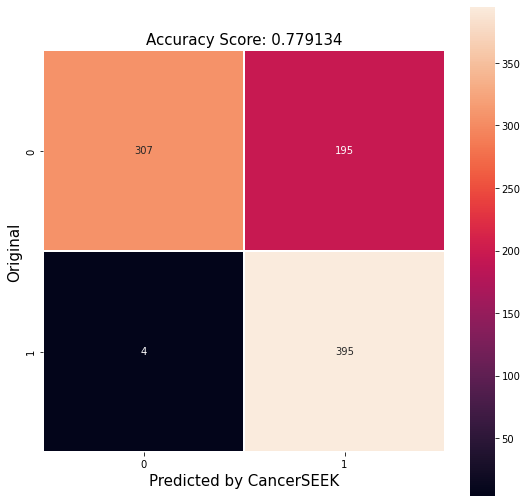

In [29]:
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test, y_cs.values.astype(float)),
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True);
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted by CancerSEEK',fontsize=15)
all_sample_title = 'Accuracy Score: %f' % accuracy(y_cs.values, y_test)
plt.title(all_sample_title, size = 15)

### Creating ROC curve

In [30]:
y_cs_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area
fpr_cs = dict()
tpr_cs = dict()
fpr_cs, tpr_cs, _ = metrics.roc_curve(y_cs.values.astype(float), y_cs_score)
roc_auc_cs = metrics.auc(fpr_cs, tpr_cs)

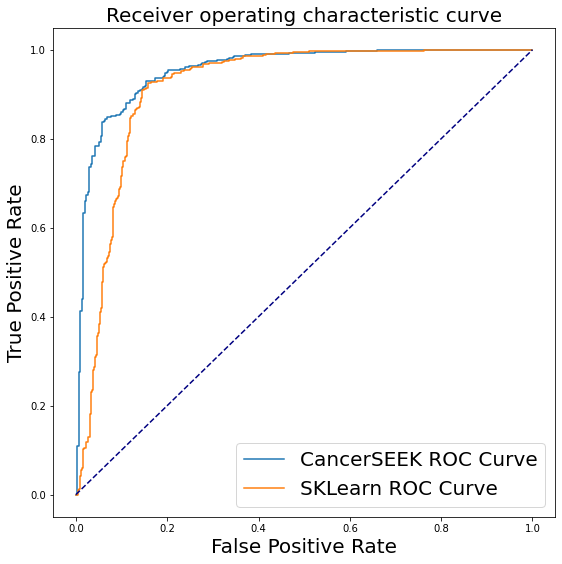

In [31]:
plt.figure(figsize=(9,9))
plt.plot(fpr_cs,tpr_cs, label='CancerSEEK ROC Curve')
plt.plot(fpr,tpr, label='SKLearn ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver operating characteristic curve',fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [32]:
print('Area under ROC %.10f' %roc_auc_cs)

Area under ROC 0.9549566734


### My model was more successful than CancerSEEK regarding accuracy, but concerning ROC, CancerSEEK seems to be better

### 4. Hepatocellular carcinoma

* fit a logistic regression (using statsmodels API this time) to predict if a sample has Hepatocellular carcinoma (liver cancer) or not. You need to keep only the liver and the normal samples for this exercise! For fitting use only the first 25 features and all the rows (which are liver or normal)
* select the 5 best predictor based on P values.
* Write down the most important features (based on P value) and compare them to the tumor markers that you find on wikipeida https://en.wikipedia.org/wiki/Hepatocellular_carcinoma or other sources!

In [33]:
newdw = [df[df['Tumor type'] == 6.0],df[df['Tumor type'] == 4.0]]
liv_norm_df = pd.concat(newdw)
liv_norm_df = liv_norm_df.replace([6.0,4.0],[1,0])
Y_sm = liv_norm_df[liv_norm_df.columns[0]]
liv_norm_scal_df = pd.DataFrame(StandardScaler().fit_transform(liv_norm_df[liv_norm_df.columns[2:27]]),columns=liv_norm_df[liv_norm_df.columns[2:27]].columns)

In [34]:
#X_sm = liv_norm_df[liv_norm_df.columns[2:27]]
#Y_sm = liv_norm_df[liv_norm_df.columns[0]]

In [35]:
X_sm = liv_norm_scal_df[liv_norm_scal_df.columns]

In [36]:
liv_norm_scal_df

,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),...,GDF15 (ng/ml),HE4 (pg/ml),HGF (pg/ml),IL-6 (pg/ml),IL-8 (pg/ml),Kallikrein-6 (pg/ml),Leptin (pg/ml),Mesothelin (ng/ml),Midkine (pg/ml),Myeloperoxidase (ng/ml)
0,-0.130498,-0.483994,0.305638,0.185864,0.552312,-0.017257,0.481683,-0.083849,-0.143977,-0.473771,...,-0.071649,-0.134287,-0.164400,-0.236315,-0.209974,0.368356,-0.096510,0.461911,-0.017045,0.021164
1,-0.137778,-0.485948,-0.024943,-0.050162,-0.895378,-0.054561,2.450559,-0.101607,-0.143977,-0.407468,...,-0.368418,-0.134287,-0.223721,-0.263540,-0.209974,-0.240556,-0.543945,-0.373837,-0.160780,0.507661
2,-0.145579,-0.260032,1.341120,0.066682,0.089264,-0.054561,0.738619,-0.141099,-0.143977,-0.672681,...,-0.352799,-0.134287,0.051575,-0.236315,-0.209974,1.932870,0.549356,-0.521733,-0.184131,-0.013254
3,-0.145579,-0.891215,1.262118,-0.068390,0.868108,-0.054561,1.461309,0.104260,-0.143977,-0.783187,...,-0.274702,-0.134287,0.090663,-0.263540,-0.209974,0.495245,-0.349022,0.230877,-0.122287,0.230227
4,-0.119728,-0.627439,0.953776,-0.068390,-0.346285,-0.054561,0.505741,-0.140214,-0.143977,0.476577,...,-0.212224,-0.026976,-0.095451,-0.152615,-0.177402,-0.790783,1.233218,-0.581242,0.142222,-0.119065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,8.152533,-0.291640,-0.642294,-0.044153,-0.466038,0.126098,-0.927131,0.016573,3.280033,0.056655,...,0.443791,-0.102247,2.038097,2.297020,0.438902,-1.597631,2.043905,-1.244590,-0.455197,0.533241
839,-0.140395,0.923923,0.513688,-0.067188,-0.196371,-0.053750,-0.533548,-0.078828,-0.086972,0.233464,...,2.646129,-0.171062,0.939264,11.349113,0.600018,-0.547755,-0.615773,0.161742,0.299854,8.091157
840,8.127354,-0.401363,0.441395,0.362132,-0.184839,-0.053750,-0.612457,-0.138815,-0.171900,0.564981,...,1.459053,-0.171062,0.856088,9.413293,0.271690,-0.384617,-0.657780,-0.810526,0.447978,1.622977
841,2.145285,-0.074262,-1.621814,-0.044153,8.351389,-0.044880,-1.148461,0.013196,16.131841,0.056655,...,0.943613,-0.102247,0.531136,0.217034,0.123347,-0.807522,-0.570760,-0.963673,-0.393300,1.938781


In [37]:
Y_sm = Y_sm.reset_index(drop=True)

In [38]:
res = sm.Logit(Y_sm,X_sm).fit()

Optimization terminated successfully.
         Current function value: 0.090319
         Iterations 12


In [39]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Tumor type   No. Observations:                  843
Model:                          Logit   Df Residuals:                      818
Method:                           MLE   Df Model:                           24
Date:                Thu, 14 Oct 2021   Pseudo R-squ.:                  0.5593
Time:                        23:45:10   Log-Likelihood:                -76.139
converged:                       True   LL-Null:                       -172.75
Covariance Type:            nonrobust   LLR p-value:                 2.124e-28
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
AFP (pg/ml)               -28.3737      3.075     -9.228      0.000     -34.400     -22.347
Angiopoietin-2 (pg/ml)      1.4203      0.480      2.958      0.003       0.479       2.361
AXL (pg/ml)                -0.2528      0.261     -0.969      0.333      -0.764       0.259
CA-125 (U/ml)             -12.7605      3.058     -4.173      0.000     -18.754      -6.767
CA 15-3 (U/ml)              0.0644      0.253      0.254      0.799      -0.432       0.560
CA19-9 (U/ml)             -10.5037      3.868     -2.715      0.007     -18.086      -2.922
CD44 (ng/ml)                1.3218      0.505      2.617      0.009       0.332       2.312
CEA (pg/ml)                -1.3503      2.074     -0.651      0.515      -5.415       2.714
CYFRA 21-1 (pg/ml)         -0.1371      0.258     -0.531      0.595      -0.643       0.369
DKK1 (ng/ml)                0.7324      0.323      2.271      0.023       0.100       1.365
Endoglin (pg/ml)           -0.1152      0.206     -0.558      0.577      -0.520       0.289
FGF2 (pg/ml)                0.4493      0.323      1.389      0.165      -0.184       1.083
Follistatin (pg/ml)        -0.4127      0.302     -1.365      0.172      -1.005       0.180
Galectin-3 (ng/ml)         -0.4570      0.379     -1.207      0.227      -1.199       0.285
G-CSF (pg/ml)              -0.0614      0.306     -0.200      0.841      -0.662       0.539
GDF15 (ng/ml)               2.6268      0.716      3.669      0.000       1.223       4.030
HE4 (pg/ml)                 0.6182      0.545      1.135      0.257      -0.450       1.686
HGF (pg/ml)                -4.8405      0.985     -4.916      0.000      -6.770      -2.911
IL-6 (pg/ml)               -0.4310      0.309     -1.394      0.163      -1.037       0.175
IL-8 (pg/ml)               -0.4336      0.240     -1.806      0.071      -0.904       0.037
Kallikrein-6 (pg/ml)        0.2725      0.255      1.069      0.285      -0.227       0.772
Leptin (pg/ml)              0.1209      0.299      0.404      0.686      -0.466       0.707
Mesothelin (ng/ml)         -0.6850      0.328     -2.090      0.037      -1.327      -0.043
Midkine (pg/ml)             0.1289      0.240      0.538      0.591      -0.341       0.599
Myeloperoxidase (ng/ml)    -0.5595      0.343     -1.631      0.103      -1.232       0.113
===========================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [40]:
results = pd.DataFrame(res.pvalues,res.pvalues.index)

In [41]:
results.sort_values(0, ascending=False)[0:5]

,0
G-CSF (pg/ml),0.841190
CA 15-3 (U/ml),0.799129
Leptin (pg/ml),0.686138
CYFRA 21-1 (pg/ml),0.595456
Midkine (pg/ml),0.590884


### https://en.wikipedia.org/wiki/Tumor_marker
#### here we can see:
* CYFRA 21-1: Many types of carcinoma, some types of sarcoma
* CA 15-3: (HUN) https://www.synlab.hu/lakossagi/vizsgalat/ca-15-3, mostly related to breast cancer and liver
* Midkine: related to bunch of cancer, including liver: https://www.nature.com/articles/s41388-019-1124-8
* Leptin: Related to obesity and https://bmccancer.biomedcentral.com/articles/10.1186/s12885-020-07651-1 liver cancer as well
* G-CSF: This seems to be highest one, however https://www.nature.com/articles/bmt2014278 study shows that it is used in cancer treatment, therefore that's why it is the highest one

### 5. Multiclass classification

* Again, using every second datapoint train a logistic regression (sklearn API) to predict the tumor type. It is a multiclass classification problem.
* Generate prediction for the rest of the dataset and show the confution matrix for the predictions!
* Plot the ROC curves for the different cancer types on the same plot!
* Intepret your results. Which cancer type can be predicted the most reliably?

In [42]:
X_5 = df[df.columns[1:]]
X_train_5 = X_5[::2]
X_test_5 = X_5[1::2]

y_5 = df[df.columns[0]]
y_train_5 = y_5[::2]
y_test_5 = y_5[1::2]

clf_5 = LogisticRegression().fit(X_train_5, y_train_5)

ypred5 = clf_5.predict(X_test_5)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
accuracy(y_test_5,ypred5)
score = clf_5.score(X_test_5, y_test_5)
print(accuracy(y_test_5,ypred5))
print(score)

0.6692563817980022
0.6692563817980022


[[ 25  31   0   0   1  39   0   4   2]
 [ 13 133   9   0   3  25   4   2   8]
 [  0   9   2   0   1   4   0   1   2]
 [  2   5   3   8   0   0   0   1   5]
 [  7  22   0   0  11   7   2   0   0]
 [  9   5   0   1   2 380   0   1   1]
 [  2   4   0   0   0   2  19   0   1]
 [  1   6   1   0   1  17   1  21   0]
 [  2  15   1   0   4   6   0   3   4]]


Text(0.5, 1.0, 'Accuracy Score: 0.669256')

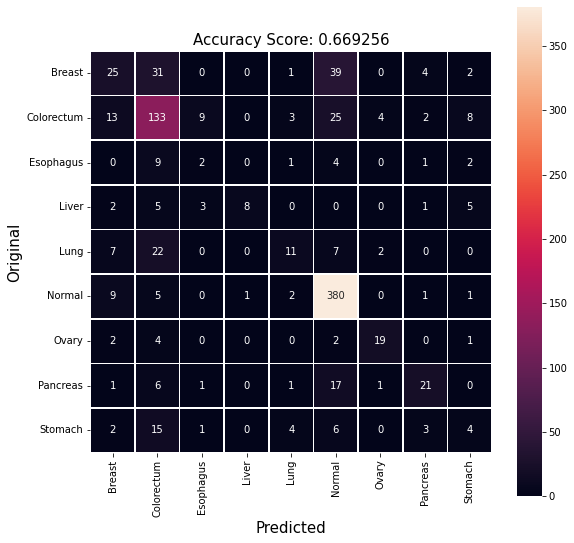

In [44]:
cm = metrics.confusion_matrix(y_test_5, ypred5)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True,
           xticklabels=tumor_types,
           yticklabels=tumor_types);
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)
all_sample_title = 'Accuracy Score: %f' % score
plt.title(all_sample_title, size = 15)

In [45]:
TP = []
FP = []
TN = []
FN = []
for i in range(9):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp #
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - fn - fp - tp
    TP.append(tp)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)

print(TP,TN,FP,FN)

TP = np.array(TP)
TN = np.array(TN)
FP = np.array(FP)
FN = np.array(FN)

[25, 133, 2, 8, 11, 380, 19, 21, 4] [763, 607, 868, 876, 840, 402, 866, 841, 847] [36, 97, 14, 1, 12, 100, 7, 12, 19] [77, 64, 17, 16, 38, 19, 9, 27, 31]


### Making ROC Curve

In [46]:
y_test_5 = label_binarize(y_test_5, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9]) #onehot_encoding in a new way

In [47]:
y_score_5 = clf_5.decision_function(X_test_5) #confidence score

In [48]:
print(y_test_5)

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [49]:
np.shape(y_test_5)

(901, 9)

In [50]:
# Compute ROC curve and ROC area for each class
fpr_5 = dict()
tpr_5 = dict()
roc_auc = dict()
for i in range(np.shape(y_test_5)[1]):
    fpr_5[i], tpr_5[i], _ = metrics.roc_curve(y_test_5[:,i], y_score_5[:, i])
    roc_auc[i] = metrics.auc(fpr_5[i], tpr_5[i])

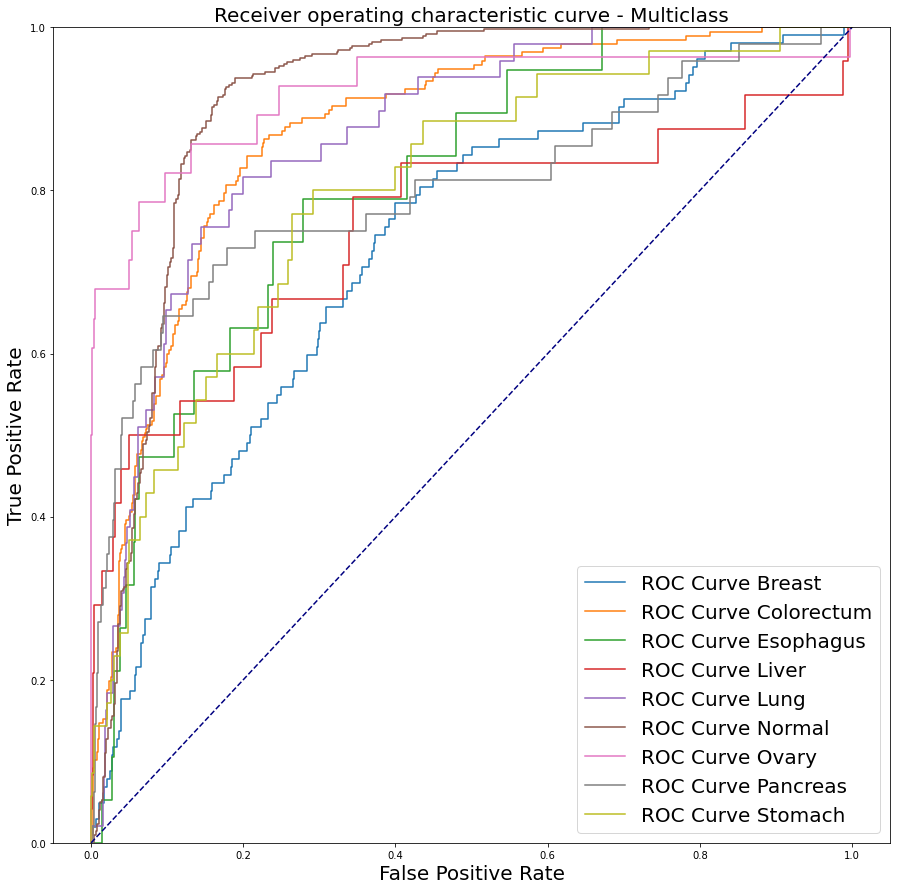

In [51]:
plt.figure(figsize=(15,15))
for i in range(np.shape(y_test_5)[1]):
    plt.plot(fpr_5[i],tpr_5[i], label='ROC Curve %s' %tumor_types[i])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver operating characteristic curve - Multiclass',fontsize=20)
plt.ylim(0.0,1.0)
plt.legend(fontsize=20)
plt.show()

Based on this, ovary, colorectum and then liver.

(Maybe removal of normal type would help to have better results?)

### Hints:

* On total you can get 10 points for fully completing all tasks.
* Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
* Comments you code when necessary
* Write functions for repetitive tasks!
* Use the pandas package for data loading and handling
* Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
* Use the scikit learn package for almost everything
* Use for loops only if it is really necessary!
* Code sharing is not allowed between student! Sharing code will result in zero points.
* If you use code found on web, it is OK, but, make its source clear!